In [50]:
import numpy as np
import ot
import time 
import matplotlib.pyplot as plt
import sys
sys.path.append('C:/Users/eriki/OneDrive/Documents/all_folder/Thesis/Thesis/utils')
from utils.utils import *
from utils.Visualizations import *
from scipy.stats import norm, sem, t
from ot.datasets import make_1D_gauss as gauss
from tqdm import tqdm

## Example

In [318]:
res = 500
lin_space = np.linspace(0, 1, res)
x = gauss(res, res * 0.35, res * 0.1)
y = gauss(res, res * 0.65, res * 0.1)

In [319]:
c = get_distance_matrix(res, 'L2')

M = ot.dist(lin_space.reshape((res, 1)), lin_space.reshape((res, 1)), metric='euclidean')  # can be euclidean for L1 and sqeuclidean for L2
M /= M.max()

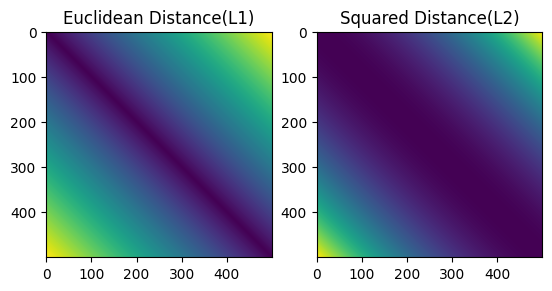

In [320]:
plt.subplot(1,2,1)
plt.imshow(ot.dist(lin_space.reshape((res, 1)), lin_space.reshape((res, 1)), metric='euclidean'))
plt.title('Euclidean Distance(L1)')
plt.subplot(1,2,2)
plt.imshow(ot.dist(lin_space.reshape((res, 1)), lin_space.reshape((res, 1)), metric='sqeuclidean'))
plt.title('Squared Distance(L2)')
plt.show()

In [321]:
ppf_x = np.cumsum(x) / np.sum(x)
ppf_y = np.cumsum(y) / np.sum(y)

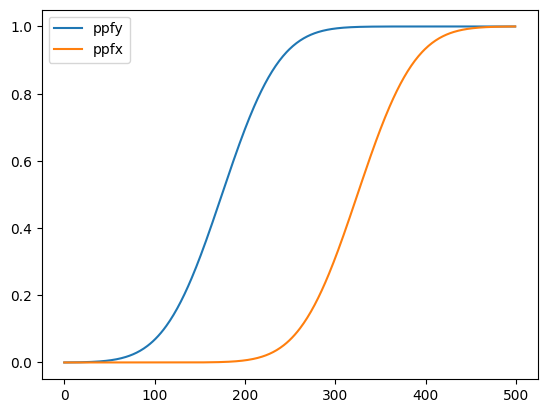

In [322]:
plt.plot(ppf_x, label='ppfy')
plt.plot(ppf_y, label='ppfx')
plt.legend()
plt.show()

$W_p(\alpha, \beta) = \int_0^1 |C_\alpha ^{-1}(r) - C_\beta ^{-1}(r)|^p dr$



In [323]:
def Wasserstein_p(p, ppf_alpha, ppf_beta):
    """
    This function is used to calculated the Wasserstein distance of power P, it takes the inverse of the CDF's of each distribution, and calculates
    the distance, it functions the same as ot.wasserstein_1d
    """
    assert len(ppf_alpha) == len(ppf_beta)
    return (np.sum((np.abs(ppf_alpha - ppf_beta)) ** p)) ** (1 / p)

In [324]:
res_pot = ot.emd(x, y, M)
res_w = Wasserstein_p(1, ppf_x, ppf_y)
res_w_ot = ot.wasserstein_1d(ppf_x, ppf_y, p=1)

This results in 0.09 since each element is moved 0.3 and the distance is squared.

In [325]:
print(f'The distance for pot library emd is : {(res_pot * M).sum()}')
print(f'The distance for my implementation of W_p on the inverse CDF functions is: {(res_w).sum()}')
print(f'The distance for ot.wasserstein_1d of W_p on the inverse CDF functions is: {(res_w_ot).sum()}')

The distance for pot library emd is : 0.30042620978783746
The distance for my implementation of W_p on the inverse CDF functions is: 149.9126786841308
The distance for ot.wasserstein_1d of W_p on the inverse CDF functions is: 0.2998253573682618


The POT modules seem to always normalzie by the resolution. Besides that it looks quite the same.

For some reason, I'm 1% off when comparing **ot.emd** to something else. 

Either way, the distance matrix and the p are different, when we define $W_2$ , we need to be aware of the metric we're using.

In [336]:
SNR = 1
signal_power = np.sum(x ** 2)
noise_param = noise_from_SNR(SNR, signal_power, res)
print(signal_power)
print(noise_param)

x_noised, x_pos, x_neg = noise_and_split(x, noise_param)
y_noised, y_pos, y_neg = noise_and_split(y, noise_param)

0.00564442235228987
0.003359887602968251


In [337]:
#Normalize the noisy measures
#x_noised /= x_noised.sum()
#y_noised /= y_noised.sum()

In [338]:
noise_y = y_noised - y
noise_x = x_noised - x
print(np.mean(noise_y))
print(np.mean(noise_x))

-0.0001203444549223777
-0.00014059481292694515


In [339]:
ppf_x_noised = np.cumsum(x_noised)
ppf_y_noised = np.cumsum(y_noised)

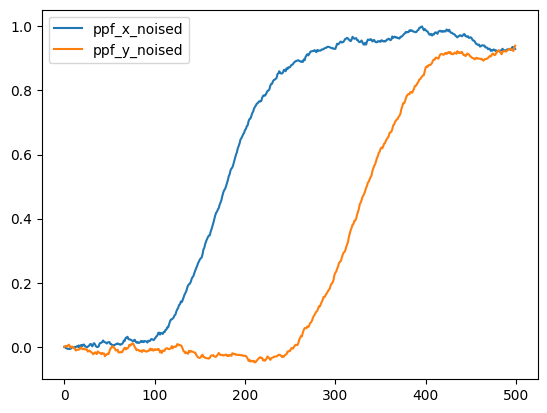

In [340]:
plt.plot(ppf_x_noised, label='ppf_x_noised')
plt.plot(ppf_y_noised, label='ppf_y_noised')
plt.legend()
plt.show()

In [341]:
# x_post, y_post = prep_signed_measures(x_pos, x_neg, y_pos, y_neg)
x_post = x_pos + y_neg
y_post = y_pos + x_neg

ppf_x_post = np.cumsum(x_post)
ppf_y_post = np.cumsum(y_post)

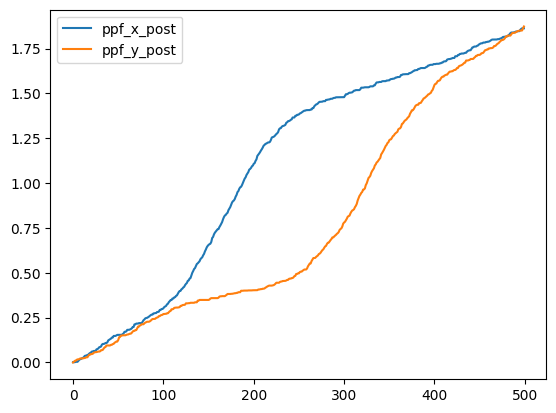

In [342]:
plt.plot(ppf_x_post, label='ppf_x_post')
plt.plot(ppf_y_post, label='ppf_y_post')
plt.legend()
plt.show()

In [343]:
ot.wasserstein_1d(ppf_x_post, ppf_y_post,p=2)

0.20124940102299926

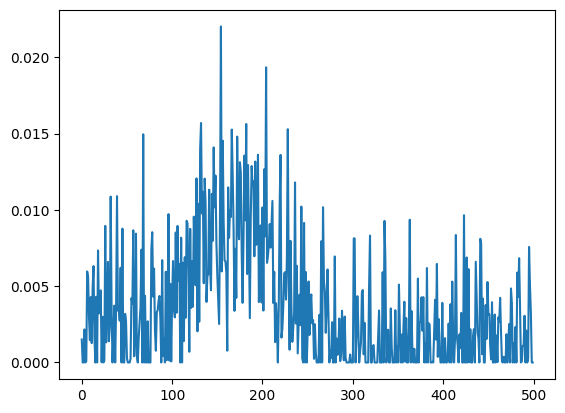

In [344]:
plt.plot(x_post)

## Different pot functions and behaviours

### ot.emd_1d

emd_1d solves the following optimization problem:

$\gamma = arg\min_\gamma \sum_i \sum_j \gamma_{ij} d(x_a[i], x_b[j])$

The result of ot.emd_1d is :  0.29982378639047236


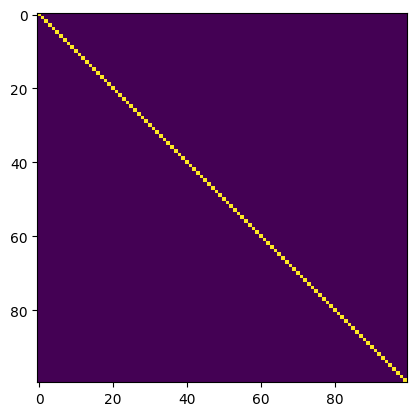

In [13]:
result_emd_1d = ot.emd_1d(ppf_x, ppf_y, metric='euclidean', log=True)
print('The result of ot.emd_1d is : ', result_emd_1d[1]['cost'])
plt.imshow(result_emd_1d[0])

I'm not quite sure about why the transport matrix liiks like this, it is also weird that we need to use the ppf's to make this legit.

### ot.emd

$\gamma = \mathop{\arg \min}_\gamma \quad \langle \gamma, \mathbf{M} \rangle_F$

The result of ot.emd  with euclid distance is :  0.30285230948532577
The result of ot.emd  with sqeuclid distance is :  0.09172198314224908


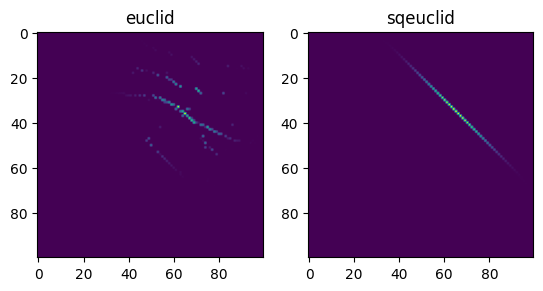

In [16]:
#When the distance matrix has a sqeuclidean distance
M = ot.dist(lin_space.reshape((res, 1)), lin_space.reshape((res, 1)), metric='euclidean')  # can be euclidean for L1 and sqeuclidean for L2
result_emd_eu = ot.emd(x, y, M, log=True)
print('The result of ot.emd  with euclid distance is : ', result_emd_eu[1]['cost'])
plt.subplot(1,2,1)
plt.title('euclid')
plt.imshow(result_emd_eu[0])

M = ot.dist(lin_space.reshape((res, 1)), lin_space.reshape((res, 1)), metric='sqeuclidean')  # can be euclidean for L1 and sqeuclidean for L2
result_emd_sq = ot.emd(x, y, M, log=True)
print('The result of ot.emd  with sqeuclid distance is : ', result_emd_sq[1]['cost'])
plt.subplot(1,2,2)
plt.title('sqeuclid')
plt.imshow(result_emd_sq[0])

The result of ot.emd is :  0.09172198314224908


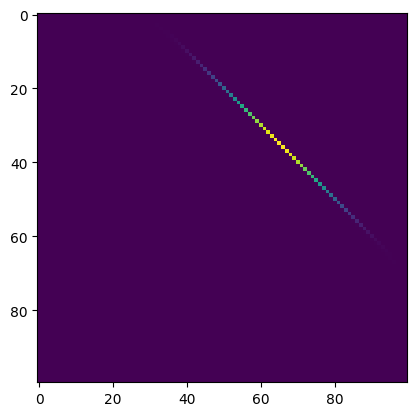

In [17]:
#When the distance matrix has a euclidean distance
result_emd = ot.emd(x, y, M, log=True)
print('The result of ot.emd is : ', result_emd[1]['cost'])
plt.imshow(result_emd[0])

### ot.wasserstein_1d

$OT_{loss} = \int_0^1 |cdf_x^{-1}(q) - cdf_y^{-1}(q)|^p dq$

In [18]:
ot.wasserstein_1d(ppf_x,ppf_y, p=1)

0.29982378639047247

## Trying to look at noisy measures

From the previous section, we can understand that ot.emd requires a squared euclid distance matrix, otherwise the output seems very strange. This does not make sense because the distances should be monotone and we should be moving quantiles around.

In [182]:
def perform_noise_and_transport_analysis_wasserstein(p, q, noise, num_samples, wasserstein_p=1, normalize_posteriors=False):
    """
    Perform noise and transport analysis for the Wasserstein distance
    :param wasserstein_p:
    :param p: source distribution
    :param q: target distribution
    :param C: cost matrix
    :param noise: noise parameter
    :param num_samples: number of samples
    :return: noise, transport, noise_std, transport_std
    """
    results = {
        'classic': [],
        'noised': [],
        'ratios_emd': [],
        'linear': [],
        'linear_noised': [],
        'ratios_linear': []
    }
    
    for i in range(num_samples):
        p /= p.sum()
        q /= q.sum()
        ppf_p = np.cumsum(p)
        ppf_q = np.cumsum(q)
        
        p_noised, p_pos, p_neg = noise_and_split(p, noise)
        q_noised, q_pos, q_neg = noise_and_split(q, noise)

        p_post, q_post = prep_signed_measures(p_pos, p_neg, q_pos, q_neg)

        if normalize_posteriors:
            p_post /= p_post.sum()
            q_post /= q_post.sum()
        
        ppf_p_post = np.cumsum(p_post)
        ppf_q_post = np.cumsum(q_post)
        

        W_distance_classic = ot.wasserstein_1d(ppf_p, ppf_q, p=wasserstein_p)
        W_distance_noised = ot.wasserstein_1d(ppf_p_post, ppf_q_post, p=wasserstein_p)
        
        results['classic'].append(W_distance_classic)
        results['noised'].append(W_distance_noised)
        results['ratios_emd'].append(W_distance_noised / W_distance_classic)
        
        # Linear
        results['linear'].append(np.linalg.norm(p - q))
        results['linear_noised'].append(np.linalg.norm(p_noised - q_noised))
        results['ratios_linear'].append(np.linalg.norm(p_noised - q_noised) / np.linalg.norm(p - q))
        
    # Compute mean and std
    results['mean_classic'], results['ci_classic'] = confidence_interval(results['classic'])
    results['mean_noised'], results['ci_noised'] = confidence_interval(results['noised'])
    
    return results

In [221]:
def run_experiment_and_append_uni(df, res, SNR, scale_param, wasserstein_p=1, num_samples=100,
                                     first_center=0.35, first_std=0.1,
                                     second_center=0.65, second_std=0.1) -> pd.DataFrame:

    # Define the distributions which we will later on noise and normalize them
    #p = gauss(res, m = res *scale_param * first_center, s = scale_param * first_std)
    #q = gauss(res, m = res * scale_param * second_center, s = scale_param * second_std)

    x = np.linspace(0, 1, res)
    p = np.where(x < 0.5, 2.0, 0)
    p = p / p.sum()
    q = np.where(x >= 0.5, 2.0, 0)
    q = q / q.sum()
    
    signal_power = (p ** 2).sum()
    noise = noise_from_SNR(SNR, signal_power=signal_power, res=res)

    results = perform_noise_and_transport_analysis_wasserstein(p, q, noise, wasserstein_p=wasserstein_p, num_samples=num_samples)

    # Create new row
    new_row = {
        'Res': res,
        'Noise_Param': noise,
        'Scale_Param': scale_param,
        'Signal_Power': signal_power,
        'SNR': SNR,
        'Wasserstein_p': wasserstein_p,
        'Distance_Classic': results['mean_classic'],
        'CI_Distances_Classic': results['ci_classic'],
        'Distances_Noised': results['mean_noised'],
        'CI_Distances_Noised': results['ci_noised'],
        'Ratios_EMD': np.mean(results['ratios_emd']),
        'Distances_Linear':  np.mean(results['linear']),
        'Distances_Linear_Noised': np.mean(results['linear_noised']),
        'Ratios_Linear': np.mean(results['ratios_linear'])
    }

    # Append new row to DataFrame
    return df._append(new_row, ignore_index=True)


def run_experiment_and_append_normal(df, res, SNR, scale_param, num_samples=100, wasserstein_p=1,
                                     first_center=0.35, first_std=0.1,
                                     second_center=0.65, second_std=0.1) -> pd.DataFrame:

    # Define the distributions which we will later on noise and normalize them
    p = gauss(res, m=res * scale_param * first_center, s=res * scale_param * first_std)
    q = gauss(res, m=res * scale_param * second_center, s=res * scale_param * second_std)

    signal_power = (p ** 2).sum()
    noise = noise_from_SNR(SNR, signal_power=signal_power, res=res)

    results = perform_noise_and_transport_analysis_wasserstein(p, q, noise, num_samples=num_samples, wasserstein_p=wasserstein_p)

    # Create new row
    new_row = {
        'Res': res,
        'Noise_Param': noise,
        'Scale_Param': scale_param,
        'Signal_Power': signal_power,
        'SNR': SNR,
        'Wasserstein_p': wasserstein_p,
        'Distance_Classic': results['mean_classic'],
        'CI_Distances_Classic': results['ci_classic'],
        'Distances_Noised': results['mean_noised'],
        'CI_Distances_Noised': results['ci_noised'],
        'Ratios_EMD': np.mean(results['ratios_emd']),
        'Distances_Linear':  np.mean(results['linear']),
        'Distances_Linear_Noised': np.mean(results['linear_noised']),
        'Ratios_Linear': np.mean(results['ratios_linear'])
    }

    # Append new row to DataFrame
    return df._append(new_row, ignore_index=True)

In [222]:
wasserstein_ps = [1,2,3]

### Uniform distributions using Wasserstein distance

Here, we see a very good performance in comparisson to SNR, since the Signal is strong

In [232]:
df_unif = pd.DataFrame()

for res in tqdm(res_values):
    for SNR in SNR_values:
        for wasserstein_p in wasserstein_ps:
            df_unif = run_experiment_and_append_uni(df=df_unif, res=res, SNR=SNR, 
                                       scale_param=scale, num_samples=500, wasserstein_p=wasserstein_p)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:04<00:00, 16.02s/it]


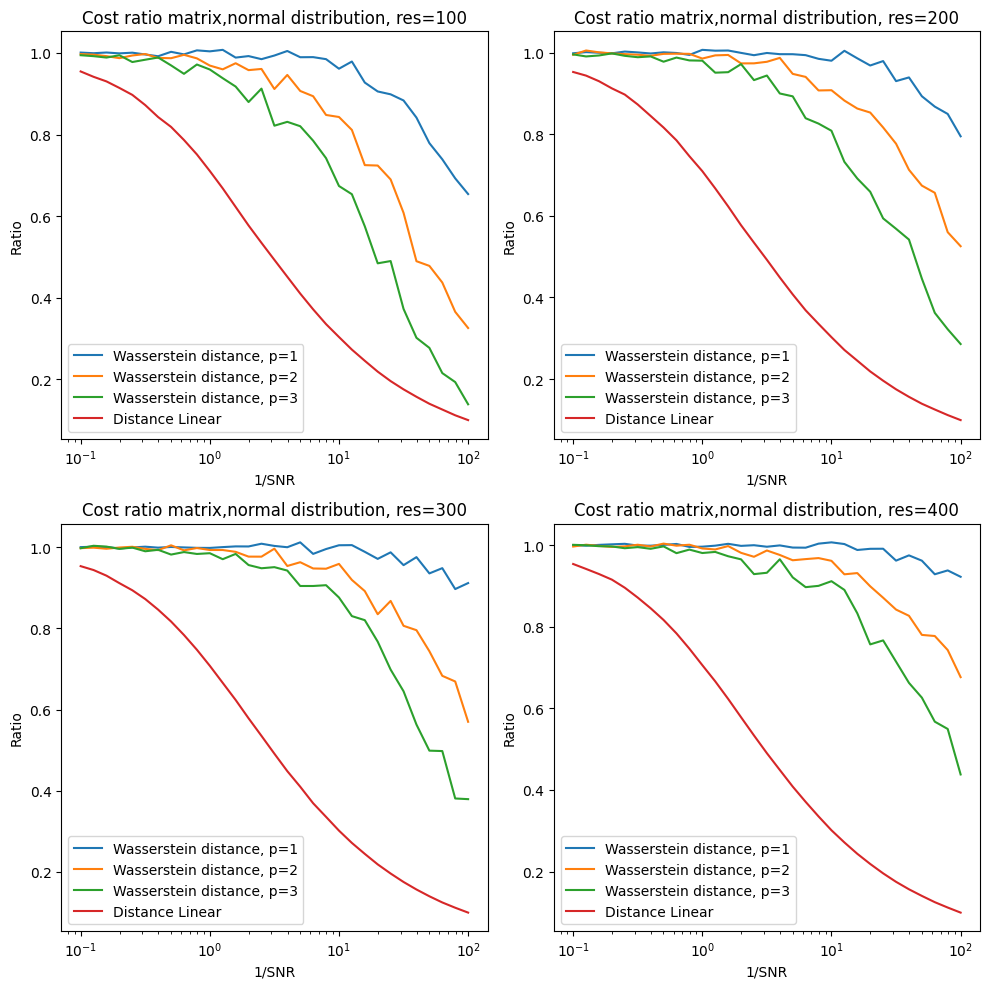

In [347]:
plt.figure(figsize=(10,10))

for i, res_option in enumerate(res_values):
    # Filter the dataframe based on current 'res' and 'scale' options
    filtered_df = df_unif[(df_unif['Res'] == res_option)]
    filtered_df1 = filtered_df[filtered_df['Wasserstein_p'] == 1]
    filtered_df2 = filtered_df[filtered_df['Wasserstein_p'] == 2]
    filtered_df3 = filtered_df[filtered_df['Wasserstein_p'] == 3]
    
    plt.subplot(2, 2, i + 1)
    plt.plot(1/filtered_df1['SNR'], 1 / filtered_df1['Ratios_EMD'], label='Wasserstein distance, p=1')
    plt.plot(1/filtered_df2['SNR'], 1 / filtered_df2['Ratios_EMD'], label='Wasserstein distance, p=2')
    plt.plot(1/filtered_df3['SNR'], 1 / filtered_df3['Ratios_EMD'], label='Wasserstein distance, p=3')

    
    plt.plot(1/filtered_df1['SNR'], 1 / filtered_df1['Ratios_Linear'], label='Distance Linear')
    plt.xscale('log')
    plt.title(f'Cost ratio matrix,normal distribution, res={res_option}')
    plt.xlabel('1/SNR')
    plt.ylabel('Ratio')
    plt.legend()

plt.tight_layout()
plt.show()

In [234]:
df_unif['Signal_Power'].min()

0.005000000000000001

### Normal distribution using Wasserstein distance

Here on the other hand, we see that Wasserstein distance gets annihilated by noise, and even when SNR is 10, the performance is still bad!

In [235]:
df_normal = pd.DataFrame()

for res in tqdm(res_values):
    for SNR in SNR_values:
        for wasserstein_p in wasserstein_ps:
            df_normal = run_experiment_and_append_normal(df=df_normal, res=res, SNR=SNR, 
                                       scale_param=scale, num_samples=500, wasserstein_p=wasserstein_p)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.59s/it]


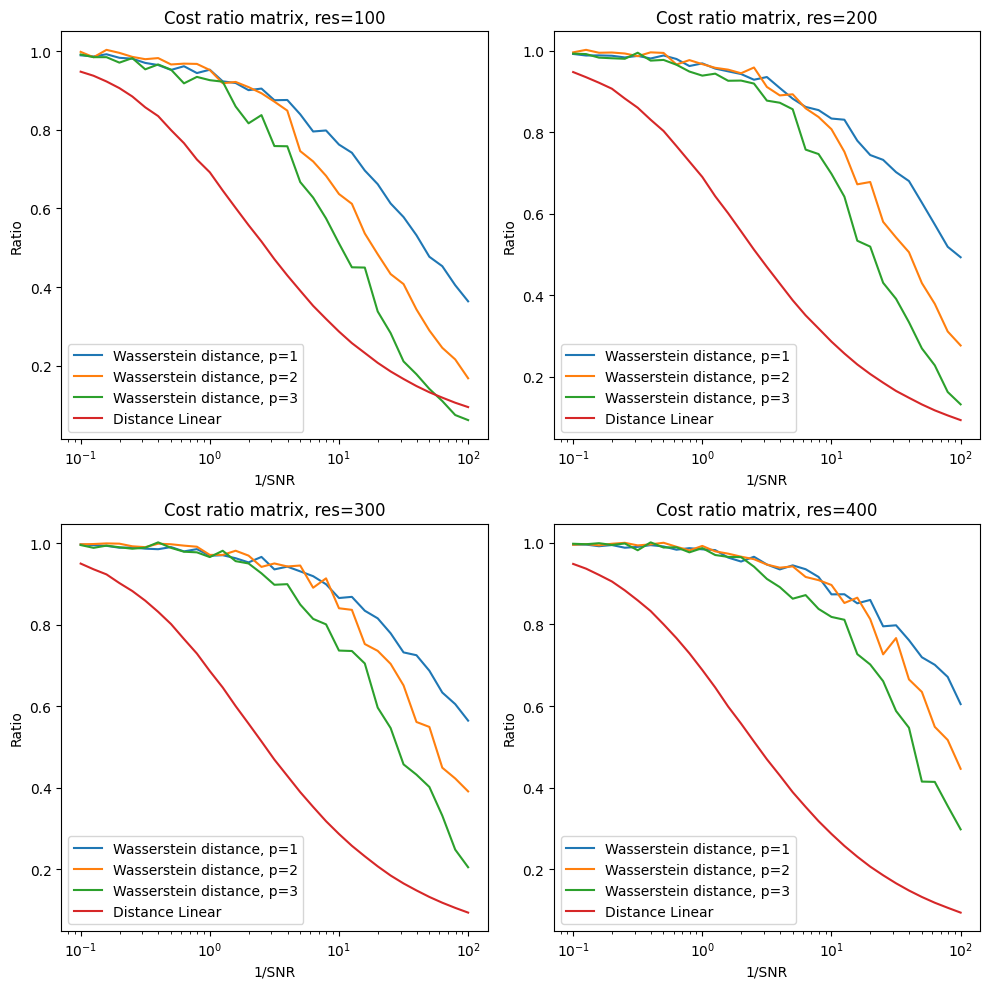

In [346]:
plt.figure(figsize=(10,10))

for i, res_option in enumerate(res_values):
    # Filter the dataframe based on current 'res' and 'scale' options
    filtered_df = df_normal[(df_normal['Res'] == res_option)]
    filtered_df1 = filtered_df[filtered_df['Wasserstein_p'] == 1]
    filtered_df2 = filtered_df[filtered_df['Wasserstein_p'] == 2]
    filtered_df3 = filtered_df[filtered_df['Wasserstein_p'] == 3]
    
    plt.subplot(2, 2, i + 1)
    plt.plot(1/filtered_df1['SNR'], 1 / filtered_df1['Ratios_EMD'], label='Wasserstein distance, p=1')
    plt.plot(1/filtered_df2['SNR'], 1 / filtered_df2['Ratios_EMD'], label='Wasserstein distance, p=2')
    plt.plot(1/filtered_df3['SNR'], 1 / filtered_df3['Ratios_EMD'], label='Wasserstein distance, p=3')

    
    plt.plot(1/filtered_df1['SNR'], 1 / filtered_df1['Ratios_Linear'], label='Distance Linear')
    plt.xscale('log')
    plt.title(f'Cost ratio matrix, res={res_option}')
    plt.xlabel('1/SNR')
    plt.ylabel('Ratio')
    plt.legend()

plt.tight_layout()
plt.show()

In [237]:
df_normal['Signal_Power'].mean()

0.014698436523467117

$W_p(\mu, \nu) = \left( \inf_{\gamma \in \Pi(\mu, \nu)} \int_{\mathbb{R}^2} |x - y|^p d\gamma(x, y) \right)^{1/p}$